Добро пожаловать на хакатон по машинному обучению!

Разрабатываем скоринг модель для вторичных клиентов банка, которая бы предсказывала вероятность дефолта клиента. Для этого:
1. Проанализировать данные, которые есть "на руках".
2. Провести EDA и Feature Engeniring.
2. Определить значимые параметры заемщика.
3. запустить нашу модель и тд

# Go-go!

In [1]:
#Сперва, конечно, подключаем нужные библиотеки
import pandas as pd
from pandas import Series
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')

Вынесем блок с функциями

In [67]:
#функция для создания boxPlot по набору колонок
def get_boxplot(column):
    #на вход наименование колоноки, в ответе боКсплоты
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x='default', y=column, 
                data=data[data.Train == 1].loc[data[data.Train == 1].loc[:, column].isin(data[data.Train == 1].loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

#создание cat_plot
def get_catplot(column):
  g = sns.catplot("default", col=column, col_wrap=7,
                data=data[data.Train == 1],
                kind="count", height=3.5, aspect=.8, 
                palette='tab20')
  #fig.suptitle('sf')
  plt.show()

#создание displot для числовых переменных
def get_displot(column):
  plt.figure()
  sns.distplot(data[data.Train == 1][column], kde = False, rug=False)
  plt.title(i)
  plt.show()

#just to calculate is customer income median, low or hight by region
def is_median_income(median, income):
  x = median/100*80
  y = median/100*120
  if x <= income <= y:
    return('median')
  elif x > income:
    return('low')
  else:
    return('hight')

#show_roc_curve just for easiest next work
def show_roc_curve(X_test, y_test):
  probs = model.predict_proba(X_test)
  probs = probs[:,1]


  fpr, tpr, threshold = roc_curve(y_test, probs)
  roc_auc = roc_auc_score(y_test, probs)

  plt.figure()
  plt.plot([0, 1], label='Baseline', linestyle='--')
  plt.plot(fpr, tpr, label = 'Regression')
  plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.legend(loc = 'lower right')
  plt.show()

In [3]:
#работаю в collab, поэтому модуль для загрузки данных
from google.colab import files
upload = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [4]:
#блок для kagle, куда потом переносить решение
#data_directory = '/kaggle/input/sf-dst-scoring/'
#df_train = pd.read_csv(data_directory+'train.csv')
#df_test = pd.read_csv(data_directory+'test.csv')

In [5]:
#Читаем данные, заодно смотрим что там творится
df_train = pd.read_csv("train.csv", sep=',')
df_test = pd.read_csv("test.csv", sep=',')
df_train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


*   client_id 	идентификатор клиента
*   app_date  - дата подачи заявки
*   education 	уровень образования
*   sex 	пол заёмщика
*   age 	возраст заёмщика
*   car 	флаг наличия автомобиля
*   car_type 	флаг автомобиля-иномарки
*   decline_app_cnt 	количество отказанных прошлых заявок
*   good_work 	флаг наличия «хорошей» работы
*   score_bki некий скор из БКИ(Бюро Кредитной Истории)
*   bki_request_cnt 	количество запросов в БКИ
*   region_rating - рейтинг региона
*   home_address 	категоризатор домашнего адреса
*   work_address 	категоризатор рабочего адреса
*   income 	доход заёмщика
*   sna - связь заемщика с клиентами банка
*   first_time - давность наличия информации о заемщике
*   foreign_passport 	наличие загранпаспорта
*   default - шанс дефолта по кредиту 

In [49]:
#разделим колонки по типам, так будет проще строить графики
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki', 'region_rating']
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
cat_cols = ['education', 'work_address', 'home_address', 'sna', 'first_time']
time_cols = ['app_date']

In [7]:
df_train.describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
count,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000
mean,55137.965094,39.280641,0.275749,0.164894,-1.904724,2.000339,56.725701,1.575509,2.496280,41099.775417,1.733330,2.765458,0.126994
std,31841.921168,11.520378,0.804272,0.371087,0.498231,2.252073,13.055717,0.527631,0.689818,46166.322400,1.123622,1.009463,0.332968
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000
25%,27440.500000,30.000000,0.000000,0.000000,-2.259534,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000
50%,55274.000000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,0.000000
75%,82758.500000,48.000000,0.000000,0.000000,-1.569831,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,0.000000
max,110147.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000


In [8]:
df_train['Train'] = 1 # отметим где фрейм для тренировки
df_test['Train'] = 0 # а где для теста

data = pd.concat([df_train, df_test], ignore_index=True) #соединим чтобы работать сразу с признаками во всех фреймах

In [38]:
#что по пропускам?
data.isna().sum()

region_rating              0
education                  0
sex                        0
age                        0
car                        0
car_type                   0
decline_app_cnt            0
good_work                  0
score_bki                  0
bki_request_cnt            0
home_address               0
work_address               0
income                     0
sna                        0
first_time                 0
foreign_passport           0
default                    0
Train                      0
date_diff_today            0
is_median_income_hight     0
is_median_income_low       0
is_median_income_median    0
is_median_income_nan       0
dtype: int64

Пропуски только в образовании и в признаке дефолта(тестовая выборка как я понимаю). Тк пропусков не много, можно не строить график для визуализации. Сразу переходим к EDA.

# EDA

Начём с пропусков в образовании. Какие вообще есть значения?

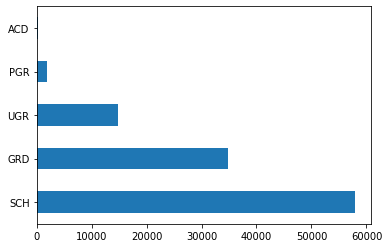

In [10]:
data['education'].value_counts().plot.barh()

Заполним пропуски самым популярным образованием в группе с таким же полом, наличичем машины, регионом, хорошей работой и загран.паспортом.

In [11]:
data['education'] = data.groupby(['sex','car','region_rating','good_work','foreign_passport'], sort=False)['education'].apply(lambda x: x.fillna(x.mode().iloc[0]))

In [12]:
#тут заполняю пропуски в Default отрицательным значением, чтобы потом легко понимать что есть что
data.default.fillna(-1, inplace=True)

Посмотрим на категориальные переменные:

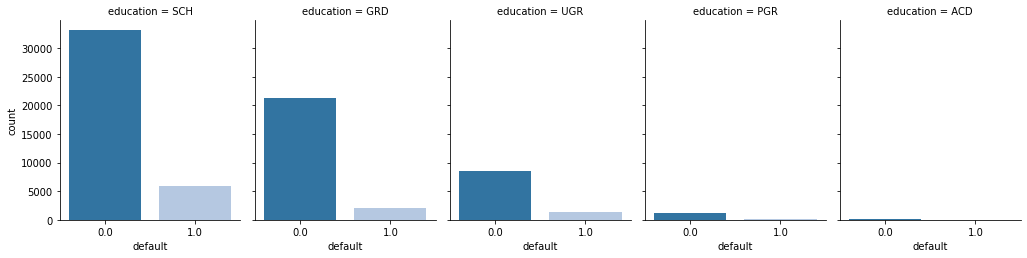

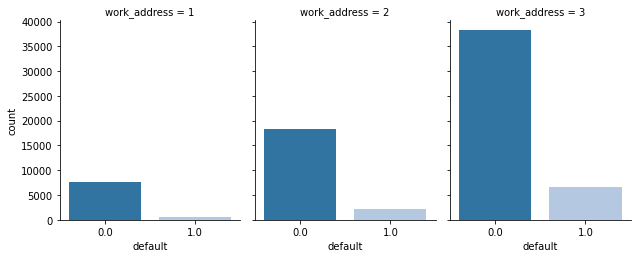

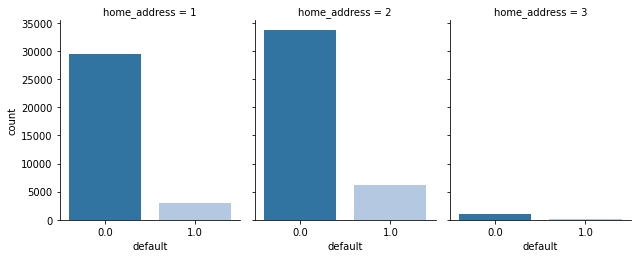

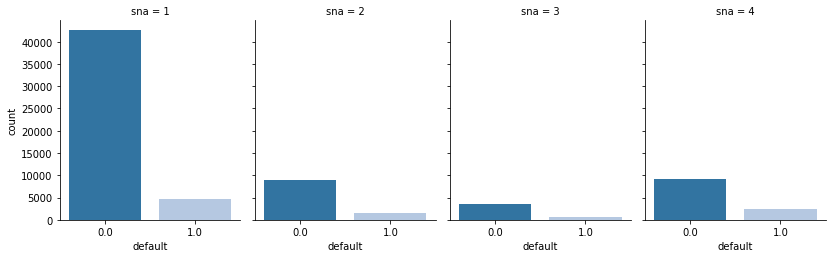

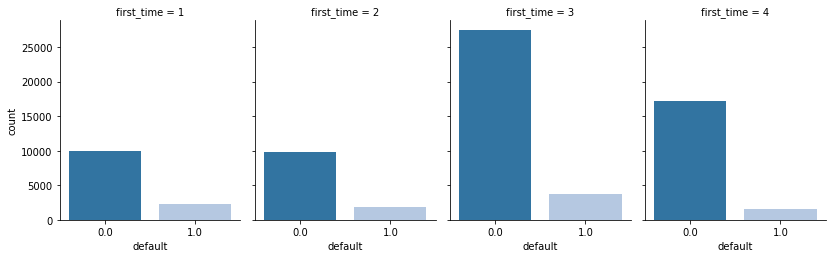

In [13]:
for col in cat_cols:
  get_catplot(col)

SNA = 4, home_address = 2 и first_time = 1 - судя по графикам, скорее всего не вернут кредит.

Людей с образованием ACD и PGR очень мало или они редко берут кредиты.

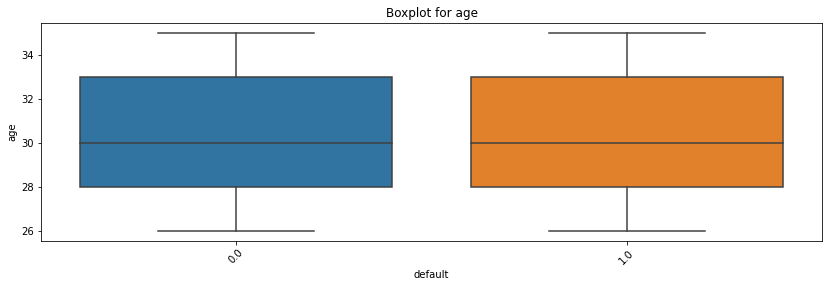

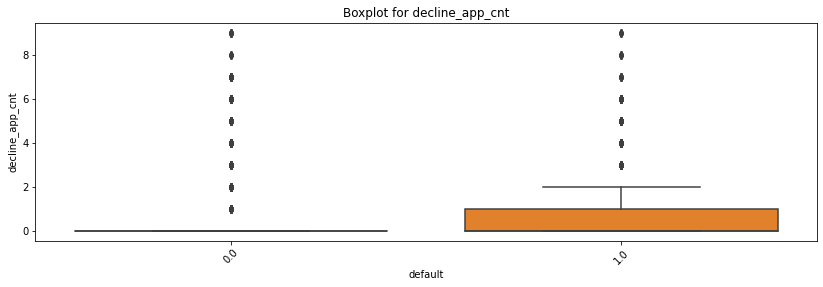

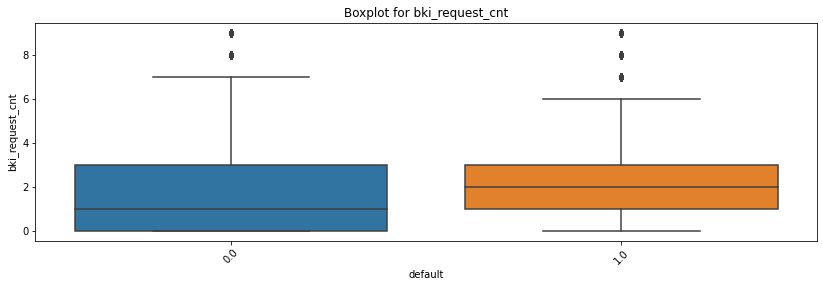

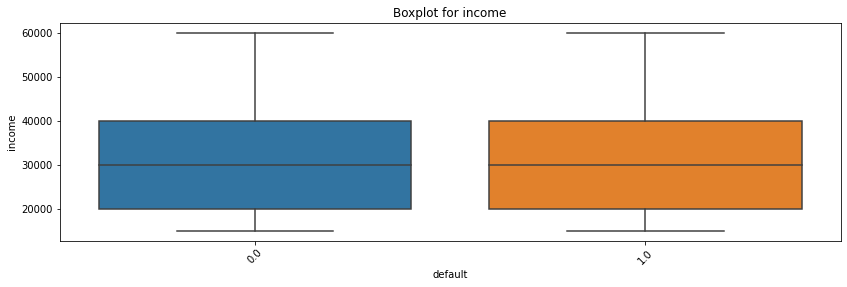

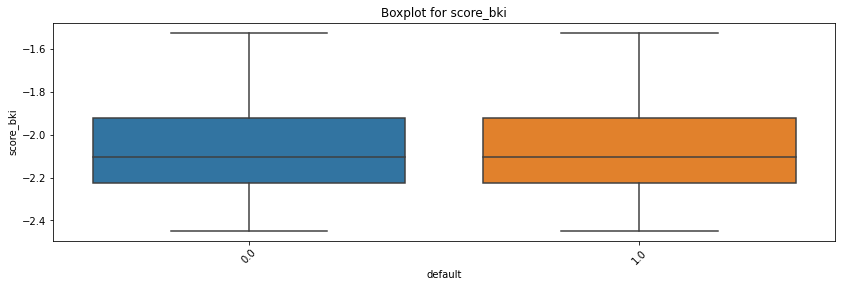

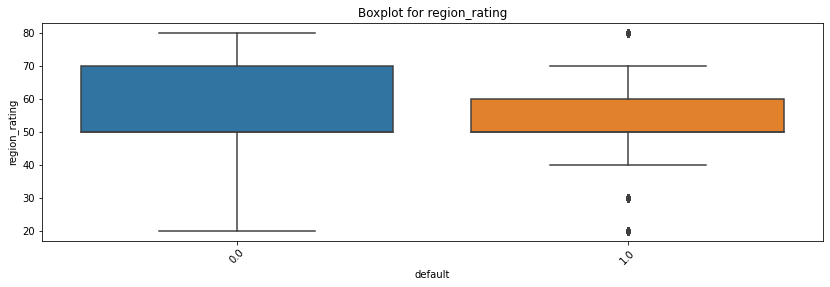

In [14]:
#А что по числовым колонкам?

for col in num_cols:
  get_boxplot(col)

Выводы:
* Если ранее отказывали в кредитах(decline_app_cnt), то есть шанс не возврата.
* 2+ запроса в бюро кредитной истории - плохой звоночек.
* Неплательщики - преимущественно - "средняя полоса"(50-60). Интересно выглядят выбросы где рейтинг 20-30 и default = 1. т.е. не вернувшие кредит там - скорее исключение из правила.

А вот: возвраст, зарплата и score БКИ не влияют на шанс возврата кредита.


Ну и проверим что по распределению числовых переменных

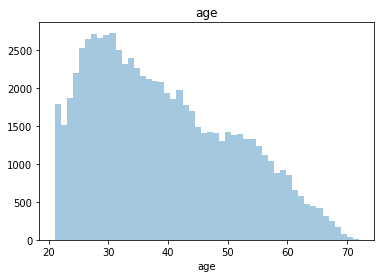

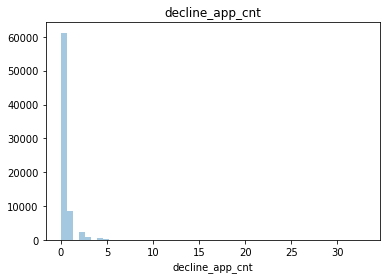

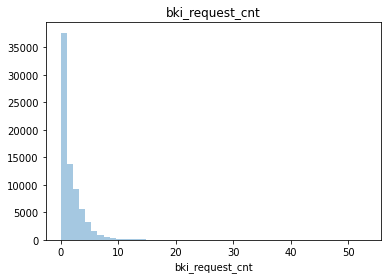

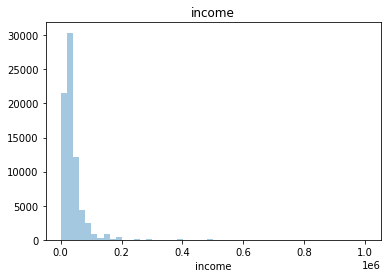

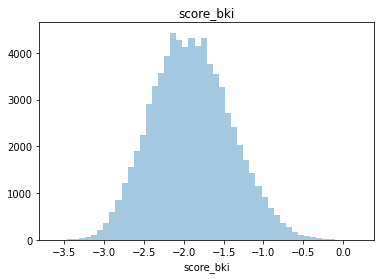

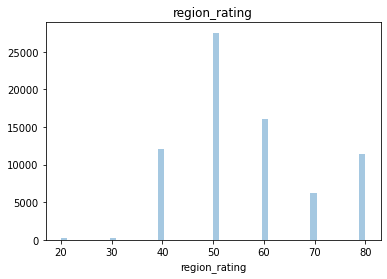

In [15]:
for i in num_cols:
  get_displot(i)

Людей с множеством отказов по кредитам всё таки не так много. 

А распределение людей по регионам объясняет один из предыдущих графиков.

Skore_BKI нужно будет привести к положительному значению чтобы проще логарифмировать.

Займёмся датой

In [16]:
#transform app_date to normal date
data['app_date'] = pd.to_datetime(data['app_date'], format='%d%b%Y')

In [17]:
#a clean date won't tell us much. Let's try to create a variable - number of days from the date to today.
data['date_diff_today'] = pd.datetime.today() - data.app_date
data['date_diff_today'] = data['date_diff_today'].dt.days
data.drop(['app_date'], axis=1, inplace=True)

data.date_diff_today.max()


2737

# Data transformation and Feature Engineering

In [18]:
#binary_cols to binary value
label_encoder = LabelEncoder()

for col in bin_cols:
  data[col] = label_encoder.fit_transform(data[col])

In [19]:
#education to 0-4 values
education_dict = {'SCH': 0,
                  'GRD': 1,
                  'UGR': 2,
                  'PGR': 3,
                  'ACD': 4 }


data['education'] = data['education'].map(education_dict)

In [20]:
#new col median_income - median_income by region_rating
median_income = data.groupby(['region_rating'], sort=True)['income'].agg(['median'])
median_income = median_income.rename(columns={'median': 'median_income'}) 

data = median_income.merge(data, on='region_rating', how='inner') #соединяем с нашим

In [21]:
#difference between median income by region and customer income
data['income_vs_median'] = data['income']-data['median_income']

In [22]:
#is customer income is median by region? categorize value
data['is_median_income'] = np.vectorize(is_median_income)(data['median_income'], data['income'])

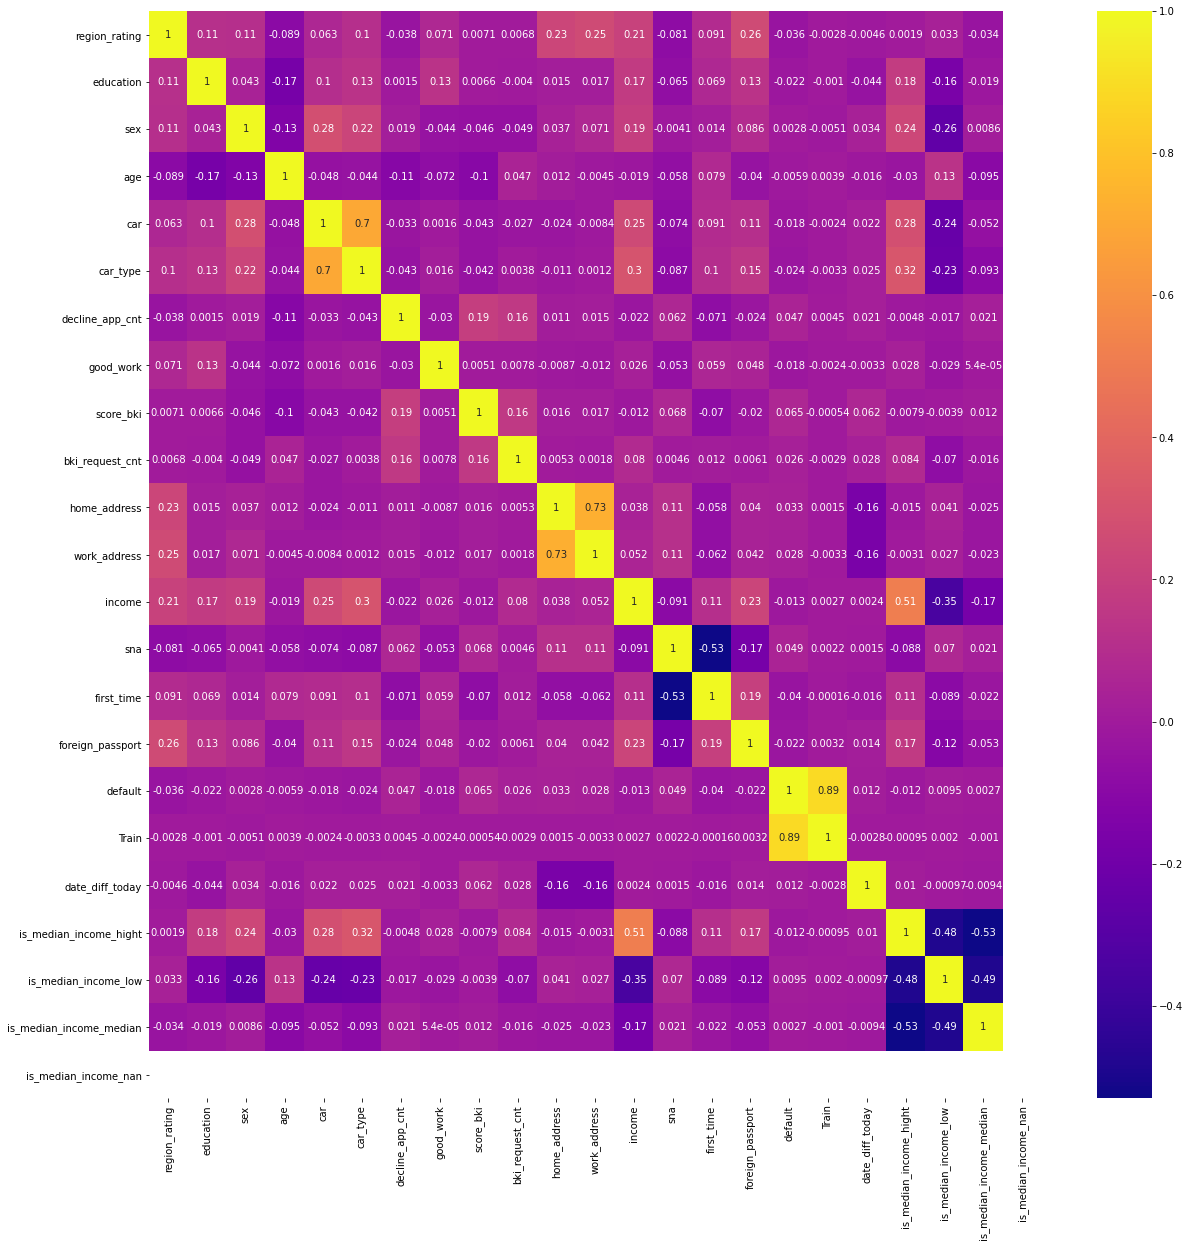

In [39]:
#let see our correlations
fig, ax = plt.subplots(1,1, figsize = (20,20))
ax = sns.heatmap(data.corr(),annot = True, cmap = 'plasma')

Can see how the Income affects the car, cat_type, foreign_passport, and so on.

In [41]:
#new feature - bki_cnt_first_time
data['bki_cnt_first_time'] = data['bki_request_cnt'] * data['first_time']

,region_rating,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,home_address,work_address,income,sna,first_time,foreign_passport,default,Train,date_diff_today,is_median_income_hight,is_median_income_low,is_median_income_median,is_median_income_nan,bki_cnt_first_time
0,20,1,0,28,0,0,0,1,2.091280,4,2,3,15000,1,2,0,0.0,1,2633,0,1,0,0,8
1,20,0,0,42,1,0,0,0,1.679805,6,2,3,25000,1,3,0,0.0,1,2664,0,0,1,0,18
2,20,0,1,35,1,0,0,0,1.836758,0,2,3,40000,4,2,0,0.0,1,2664,1,0,0,0,0
3,20,1,1,36,1,1,0,1,3.793136,0,2,3,20000,3,3,0,1.0,1,2686,0,0,1,0,0
4,20,0,1,39,0,0,0,0,1.793859,1,2,3,20000,1,3,0,1.0,1,2623,0,0,1,0,3


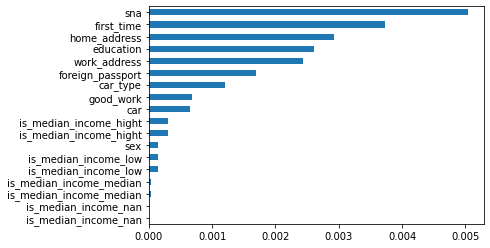

In [52]:
#add new field to list bin_cols and show dependency between default and bin_cols + cat_cols
new_cols = ['is_median_income_hight','is_median_income_low','is_median_income_median']
bin_cols.extend(new_cols)

dependency = pd.Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
dependency.sort_values(inplace = True)
dependency.plot(kind = 'barh')

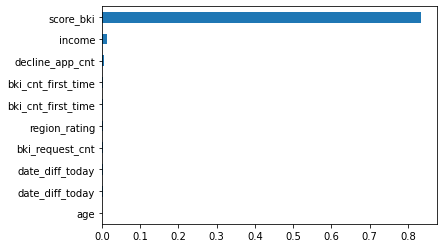

In [57]:
#add new field to list num_cols and show dependency between default and num_cols
new_cols = ['date_diff_today','bki_cnt_first_time']
num_cols.extend(new_cols)

dependency = pd.Series(mutual_info_classif(data[num_cols], data['default'],
                                     discrete_features =True), index = num_cols)
dependency.sort_values(inplace = True)
dependency.plot(kind = 'barh')

In [56]:
data.head()

,region_rating,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,home_address,work_address,income,sna,first_time,foreign_passport,default,Train,date_diff_today,is_median_income_hight,is_median_income_low,is_median_income_median,is_median_income_nan,bki_cnt_first_time
0,0.0,1,0,0.137255,0,0,0.0,1,0.546832,0.075472,2,3,0.014014,1,2,0,0.0,1,0.126050,0,1,0,0,0.050314
1,0.0,0,0,0.411765,1,0,0.0,0,0.439238,0.113208,2,3,0.024024,1,3,0,0.0,1,0.386555,0,0,1,0,0.113208
2,0.0,0,1,0.274510,1,0,0.0,0,0.480279,0.000000,2,3,0.039039,4,2,0,0.0,1,0.386555,1,0,0,0,0.000000
3,0.0,1,1,0.294118,1,1,0.0,1,0.991836,0.000000,2,3,0.019019,3,3,0,1.0,1,0.571429,0,0,1,0,0.000000
4,0.0,0,1,0.352941,0,0,0.0,0,0.469061,0.018868,2,3,0.019019,1,3,0,1.0,1,0.042017,0,0,1,0,0.018868


In [ ]:
#drop extra colums
data.drop(columns = ['income_vs_median','median_income', 'client_id', 'is_median_income_median'], inplace=True)

#data.drop(columns = ['decline_app_cnt, 'bki_cnt_first_time', 'region_rating', 'date_diff_today', 'age'], inplace=True)

# Scale numeric cols

In [25]:
#score_bki reduce to positive values to simplify the logarithm 
data.score_bki = data.score_bki - data.score_bki.min()

In [55]:
#scale 
scaler = MinMaxScaler()
data[num_cols] = scaler.fit_transform(data[num_cols].values)

# Aaaand Start

split data

In [61]:
train = data[data.Train == 1]
test = data[data.Train == 0]
train = train.drop(['Train'], axis=1)
test = test.drop(['Train','default'], axis=1)

X = train.drop('default', axis=1).values
y = train['default'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

№1 LogisticRegression

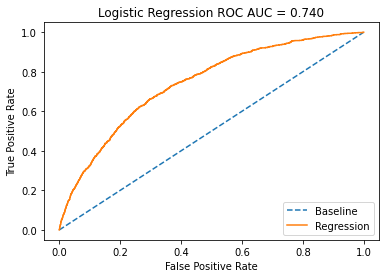

In [76]:
clf = LogisticRegression(random_state=42, max_iter = 1000).fit(X_train, y_train)
clf.score(X_train, y_train)
show_roc_curve(X_test, y_test)